In [123]:
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
import tensorflow as tf
#from ipdb import set_trace as stop
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

from keras import backend as K
from keras.layers import Dense, Input, merge
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU
from sklearn.cross_validation import train_test_split

In [127]:
def build_toy_dataset(nsample=40000):
    y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, nsample))).T
    r_data = np.float32(np.random.normal(size=(nsample,1))) # random noise
    x_data = np.float32(np.sin(0.75*y_data)*7.0+y_data*0.5+r_data*1.0)
    return train_test_split(x_data, y_data, random_state=42, train_size=0.1)

def log_sum_exp(x, axis=None):
    """Log-sum-exp trick implementation"""
    x_max = K.max(x, axis=axis, keepdims=True)
    return K.log(K.sum(K.exp(x - x_max), 
                       axis=axis, keepdims=True))+x_max

def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
    """
    Draws samples from mixture model. 
    Returns 2 d array with input X and sample from prediction of Mixture Model
    """
    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j,(weights, means, std_devs) in enumerate(zip(pred_weights, pred_means, pred_std)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j,1]= normal.rvs(means[index], std_devs[index], size=1)
        samples[j,0]= x[j]
        if j == amount -1:
            break
    return samples

def sample_mixture(mu, sigma, alpha):
    n_samples, n_mixture = mu.shape
    samples = np.zeros(n_samples)
    for i in range(n_samples):
        ind = np.random.choice(n_mixture, p=alpha[i,:])
        samples[i] = np.random.normal(loc=mu[i,ind], scale=sigma[i,ind])
    return samples

def elu_modif(x, a=1.):
    e=1e-15
    return ELU(alpha=a)(x)+1.+e

In [170]:
class MixtureDensityNetwork:
    """
    Mixture density network for outputs y on inputs x.
    p((x,y), (z,theta))
    = sum_{k=1}^K pi_k(x; theta) Normal(y; mu_k(x; theta), sigma_k(x; theta))
    where pi, mu, sigma are the output of a neural network taking x
    as input and with parameters theta. There are no latent variables
    z, which are hidden variables we aim to be Bayesian about.
    """
    def __init__(self, d, m):
        self.d = d
        self.m = m # here K is the amount of Mixtures 
        self.X_train, self.X_test, self.y_train, self.y_test = build_toy_dataset()

    def neg_log_normal_mixture(self, y_true, parameters):   
        components = K.reshape(parameters,[-1, self.d + 2, self.m])

        mu = components[:, :self.d, :]
        sigma = components[:, self.d, :]
        alpha = components[:, self.d + 1, :]
        alpha = K.softmax(K.clip(alpha,1e-8,1.))
    
        exponent = K.log(alpha) - .5 * float(self.d) * K.log(2 * np.pi) \
            - float(self.d) * K.log(sigma) \
            - K.sum((K.expand_dims(y_true,2) - mu)**2, axis=1)/(2*(sigma)**2)
    
        log_gauss = log_sum_exp(exponent, axis=1)
        res = - K.mean(log_gauss)
        return res

    def gen_model(self):
        # The network    
        inputs = Input(shape=(1,))
        hidden1 = Dense(15, activation='relu')(inputs)  # fully-connected layer with 15 hidden units
        hidden2 = Dense(15, activation='relu')(hidden1) 

        mus = Dense(self.m)(hidden2) # the means 
        sigmas = Dense(self.m, activation=elu_modif)(hidden2) # the variance
        pi = Dense(self.m, activation=K.softmax)(hidden2) # the mixture components

        parameters = merge([mus, sigmas, pi], mode='concat')

        self.model = Model(input=inputs, output=parameters)

        self.model.compile(loss=self.neg_log_normal_mixture, optimizer='rmsprop') #Adam(lr=1e-3))

    def fit_model(self):

        self.model.fit(self.X_train, self.y_train, 32, nb_epoch=200, verbose=1)
        
        
    def predict(self):
        parameters = self.model.predict(self.X_train)
        comp = np.reshape(parameters,[-1, self.d + 2, self.m])
        mu_pred = np.squeeze(comp[:, :self.d, :])
        sigma_pred = np.squeeze(comp[:, self.d, :])
        alpha_pred = np.squeeze(comp[:, self.d + 1, :])
        return mu_pred, sigma_pred, alpha_pred

In [171]:
out = MixtureDensityNetwork(1, 5)
out.gen_model()

In [172]:
out.fit_model()

Epoch 1/200
4000/4000 [==============================] - 1s - loss: 5.1278     
Epoch 2/200
4000/4000 [==============================] - 0s - loss: 3.5681     
Epoch 3/200
4000/4000 [==============================] - 0s - loss: 3.2235     
Epoch 4/200
4000/4000 [==============================] - 0s - loss: 3.1074     
Epoch 5/200
4000/4000 [==============================] - 0s - loss: 2.9792     
Epoch 6/200
4000/4000 [==============================] - 0s - loss: 2.8446     
Epoch 7/200
4000/4000 [==============================] - 0s - loss: 2.6398     
Epoch 8/200
4000/4000 [==============================] - 0s - loss: 2.5027     
Epoch 9/200
4000/4000 [==============================] - 0s - loss: 2.4315     
Epoch 10/200
4000/4000 [==============================] - 0s - loss: 2.3776     
Epoch 11/200
4000/4000 [==============================] - 0s - loss: 2.2931     
Epoch 12/200
4000/4000 [==============================] - 0s - loss: 2.2505     
Epoch 13/200
4000/4000 [=============

In [173]:
mu, sigma, alpha = out.predict()

In [174]:
res2 = sample_mixture(mu, sigma, alpha)

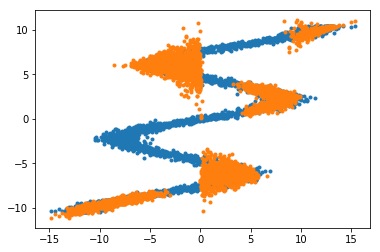

In [175]:
pl.plot(out.X_train, out.y_train, '.')
pl.plot(out.X_train, res2, '.')

In [82]:
res2